In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Extracting Images

In [ ]:
#!7za -y x "/content/drive/MyDrive/Facial_Expression/data/image/origin.7z.*"

In [ ]:
#!cp -r ./origin "/content/drive/MyDrive/Facial_Expression/Extract_Images"

# Loading Images Info

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
label_file_path = r"/content/drive/MyDrive/Facial_Expression/data/label/label.lst"
df_info = pd.read_csv(label_file_path, sep=" ", header=None)
col_names = "image_name face_id_in_image face_box_top face_box_left face_box_right face_box_bottom face_box_cofidence expression_label".split()
df_info.columns = col_names
df_info.head()

,image_name,face_id_in_image,face_box_top,face_box_left,face_box_right,face_box_bottom,face_box_cofidence,expression_label
0,angry_actor_104.jpg,0,28,113,226,141,22.9362,0
1,angry_actor_109.jpg,0,31,157,345,219,50.3056,0
2,angry_actor_120.jpg,1,53,53,372,372,13.9434,2
3,angry_actor_13.jpg,0,77,51,362,388,85.8104,3
4,angry_actor_132.jpg,0,95,31,412,476,82.3948,0


In [ ]:
df_sel = df_info[df_info.face_box_cofidence > 40]

# Loading Images

In [ ]:
from tqdm import tqdm
X = []
Y = []

images_folder_path = r"/content/drive/MyDrive/Facial_Expression/Extract_Images"

for i, row in df_sel.sample(10000).iterrows():
  img_name = row["image_name"]
  x1 = row["face_box_top"]
  x2 = row["face_box_bottom"]
  y1 = row["face_box_left"]
  y2 = row["face_box_right"]
  label = row["expression_label"]

  comb_path = os.path.join(images_folder_path, img_name)
  img = cv2.imread(comb_path)

  if img is not None:
    face = img[x1:x2, y1:y2]
  else:
    continue

  if face is not None:
    face_resized = cv2.resize(face, (128, 96))
  else:
    continue

  X.append(face_resized)
  Y.append(label)

# Data Preparation

In [ ]:
X = np.array(X)
Y = np.array(Y)

In [ ]:
X.shape

(3242, 96, 128, 3)

In [ ]:
Y.shape

(3242,)

In [ ]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(Y)

In [ ]:
y.shape

(3242, 7)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_test, X_val, y_test, y_val= train_test_split(X_test, y_test, test_size=0.35)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Initialize the ImageDataGenerator with desired augmentation options
datagen = ImageDataGenerator(
    rescale=1.0 / 255,  # Rescale pixel values to [0, 1]
    rotation_range=20,  # Randomly rotate images by 20 degrees
    width_shift_range=0.2,  # Randomly shift images horizontally by 20% of the width
    height_shift_range=0.2,  # Randomly shift images vertically by 20% of the height
    shear_range=0.2,  # Apply shear transformation with a maximum shear intensity of 20%
    zoom_range=0.2,  # Randomly zoom images by up to 20%
    horizontal_flip=True,  # Randomly flip images horizontally
    vertical_flip=True  # Randomly flip images vertically
)

# Train your datagen
datagen.fit(X)

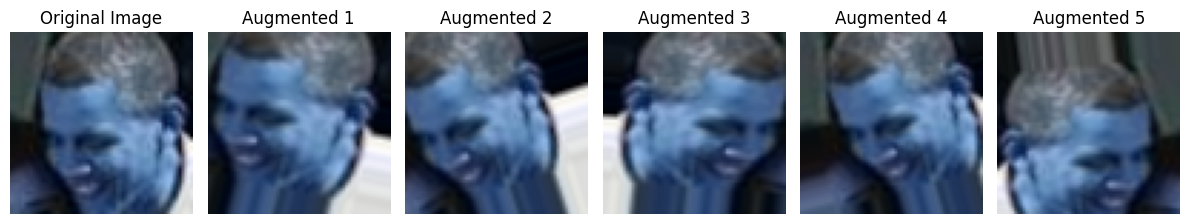

In [ ]:
# Sample image (replace this with your actual image)
sample_index = 15
sample_image = X[sample_index]

# Reshape the sample image to (1, height, width, num_channels) to match generator input
sample_image_reshaped = np.expand_dims(sample_image, axis=0)

# Number of augmented versions to visualize
num_augmented = 5

# Generate augmented images from the sample image
augmented_images = datagen.flow(sample_image_reshaped, batch_size=1)

# Plot the original and augmented images side by side
plt.figure(figsize=(12, 4))
plt.subplot(1, num_augmented + 1, 1)
plt.imshow(sample_image)
plt.title("Original Image")
plt.axis('off')

# Display augmented versions
for i in range(num_augmented):
    augmented_image = augmented_images.next()[0]
    plt.subplot(1, num_augmented + 1, i + 2)
    plt.imshow(augmented_image)
    plt.title(f"Augmented {i+1}")
    plt.axis('off')

plt.tight_layout()
plt.show()


# Model Building

In [ ]:
import tensorflow as tf

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(8, (2,2), input_shape=(64, 64, 3)))
model.add(tf.keras.layers.MaxPool2D((2,2)))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Conv2D(16, (2,2)))
model.add(tf.keras.layers.MaxPool2D((2,2)))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(32))
model.add(tf.keras.layers.Dense(y.shape[1], activation="softmax"))

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(datagen.flow(X_train, y_train), epochs=5, validation_data=(X_val, y_val))

Epoch 1/5
8/8 [==============================] - 3s 138ms/step - loss: 2.1914 - accuracy: 0.2599 - val_loss: 237.1157 - val_accuracy: 0.1714
Epoch 2/5
8/8 [==============================] - 1s 129ms/step - loss: 2.0522 - accuracy: 0.2070 - val_loss: 120.2901 - val_accuracy: 0.3714
Epoch 3/5
8/8 [==============================] - 1s 159ms/step - loss: 1.7899 - accuracy: 0.3480 - val_loss: 50.0585 - val_accuracy: 0.2571
Epoch 4/5
8/8 [==============================] - 1s 164ms/step - loss: 1.7065 - accuracy: 0.2643 - val_loss: 59.6015 - val_accuracy: 0.4286
Epoch 5/5
8/8 [==============================] - 1s 94ms/step - loss: 1.6270 - accuracy: 0.3789 - val_loss: 57.0910 - val_accuracy: 0.3714


# Plotting Model Architecture

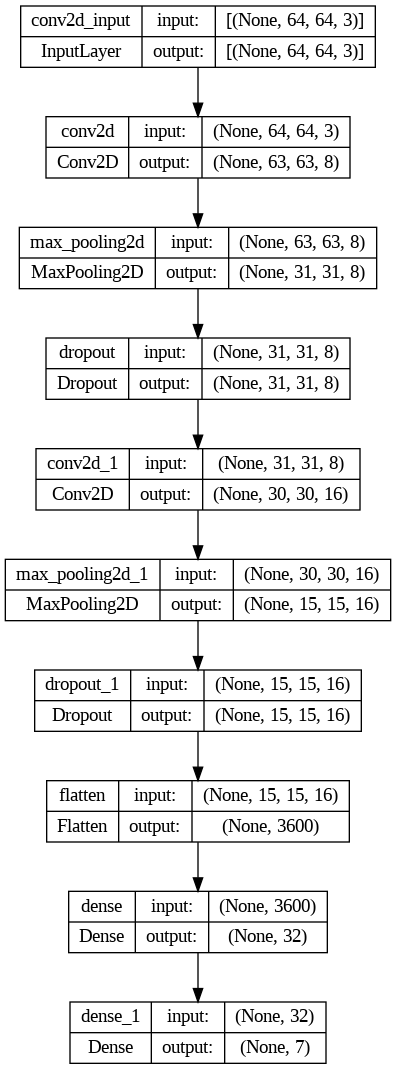

In [ ]:
from tensorflow.keras.utils import plot_model
# Visualize the model architecture
plot_model(history, to_file='/content/drive/MyDrive/Facial_Expression/model_architecture.png', show_shapes=True, show_layer_names=True)

# Plotting Training & Validation

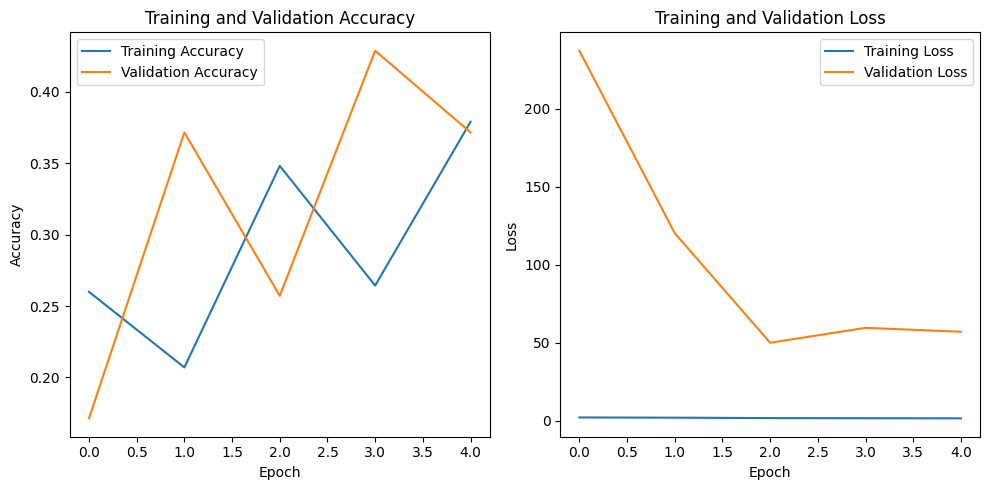

In [ ]:
# Plot training and validation accuracy curves
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss curves
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Plotting Confusion Matrix

2/2 [==============================] - 0s 43ms/step


ValueError: ignored

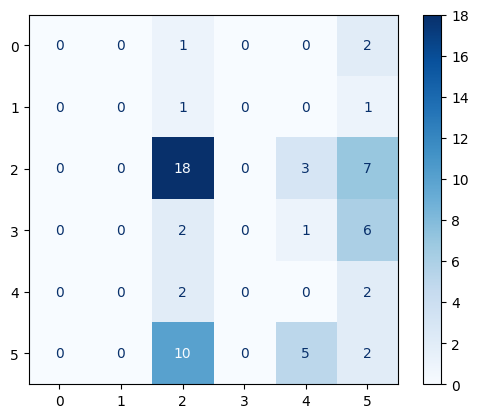

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Assuming you have already trained the model and now want to evaluate it on the test dataset
# Replace `model` with your trained model
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)

# Get the class labels
class_names = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)

plt.title('Confusion Matrix')
plt.show()

# Your's Expression

In [ ]:

# Function to preprocess the uploaded image
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (64, 64))
    img = img.astype(np.float32) / 255.0
    img = np.expand_dims(img, axis=0)
    return img

# Function to get the expression label
def get_expression_label(predictions):
    expression_labels = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
    expression_label = np.argmax(predictions[0])
    return expression_labels[expression_label]

if __name__ == "__main__":
    # Replace 'path_to_image' with the actual path to your face image
    image_path = '/content/drive/MyDrive/Facial_Expression/kheem_dharmani.jpg'

    # Preprocess the image
    img = preprocess_image(image_path)

    # Make predictions using the model
    predictions = model.predict(img)
    predicted_expression = get_expression_label(predictions)

    # Display the result
    print("Predicted Expression:", predicted_expression)


1/1 [==============================] - 0s 130ms/step
Predicted Expression: neutral


# Transfer Learning

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

In [ ]:
# Preprocess input for VGG16
X_train_preprocessed = preprocess_input(X_train)
X_test_preprocessed = preprocess_input(X_test)


In [ ]:
# Load the pre-trained VGG16 model without the top classification layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(96, 128, 3))

In [ ]:
# Add custom classification layers on top of the base VGG16 model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(y_train.shape[1], activation='softmax')(x)

In [ ]:
# Create the transfer learning model
VGGmodel = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
# Freeze the pre-trained layers in the base model
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# Compile the model
VGGmodel.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
VGGmodel.fit(X_train_preprocessed, y_train, batch_size=32, epochs=10, validation_split=0.1)

Epoch 1/10
64/64 [==============================] - 357s 6s/step - loss: 3.5446 - accuracy: 0.3976 - val_loss: 2.1734 - val_accuracy: 0.4626
Epoch 2/10
64/64 [==============================] - 317s 5s/step - loss: 1.3867 - accuracy: 0.5798 - val_loss: 2.1106 - val_accuracy: 0.4361
Epoch 3/10
64/64 [==============================] - 317s 5s/step - loss: 0.8552 - accuracy: 0.7101 - val_loss: 2.1155 - val_accuracy: 0.4626
Epoch 4/10
64/64 [==============================] - 313s 5s/step - loss: 0.5959 - accuracy: 0.7899 - val_loss: 1.8173 - val_accuracy: 0.5374
Epoch 5/10
64/64 [==============================] - 310s 5s/step - loss: 0.3894 - accuracy: 0.8697 - val_loss: 1.9743 - val_accuracy: 0.5683
Epoch 6/10
64/64 [==============================] - 300s 5s/step - loss: 0.2626 - accuracy: 0.9319 - val_loss: 1.9658 - val_accuracy: 0.5551
Epoch 7/10
64/64 [==============================] - 310s 5s/step - loss: 0.1840 - accuracy: 0.9628 - val_loss: 1.9479 - val_accuracy: 0.5683
Epoch 8/10
64

In [ ]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test_preprocessed, y_test)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

NameError: ignored